In [7]:
# Importamos las librerías que vamos a necesitar

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [8]:
# Importamos el dataset

users_behavior = pd.read_csv('/datasets/users_behavior.csv')
users_behavior.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [9]:
# Usamos el método info

users_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [10]:
# Utilizamos el método describe

users_behavior.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


**Observaciones Iniciales**

Ya que nuestro dataset ha sido trabajado previamente, podemos observar que no tenemos valores ausentes en ninguna de las columnas. Y como ya ha sido pre procesado no necesitamos hacerle ningún cambio. 
Vemos que tenemos 5 columnas con las cuales trabajaremos para realizar nuestros distintos modelos y poder escoger el que más nos sirva.  Cada columna, exceptuando la de `is_ultra`, tiene datos que nos ayudaran a que el modelo entienda el comportamiento de los clientes y así poder predecir el tipo de plan que le conviene a cada cliente según la cantidad de mensajes, llamadas, minutos, y megas que utilicen. 


## Modelos

Antes de realizar nuestros distintos modelos vamos a:
- Crear nuestros datasets de características y de objetivo
- Vamos a dividir nuestros datasets de características y objetivo en datasets de entrenamiento, validación, y prueba. 

Después crearemos y analizaremos tres diferentes tipos de modelos
- Árbol de decisión
- Bosque Aleatorio
- Regresión Logística

Y decidiremos cual es el mejor basadnos en la métrica de exactitud y el roc curve

In [11]:
# Creamos una fórmula que nos ayudara en la comprobación de nuestros modelos.

def get_roc_plot_data(y, predictions):
    fpr, tpr, _ = roc_curve(y,
                            predictions,
                            pos_label=None,
                            drop_intermediate=True)
    auc = round(roc_auc_score(y, predictions), 5)

    return fpr, tpr, auc


def plot_roc(custom_axis, y, predictions):

    multiple_curves = isinstance(y, dict)

    custom_axis.axis([-0.01,1.01,0,1.01])
    custom_axis.set(xlabel="False Positive Rate", ylabel="Recall")
    custom_axis.set_title("ROC Curve")

    if not multiple_curves:
        fpr, tpr, auc = get_roc_plot_data(y, predictions)

        custom_axis.plot(fpr, tpr)
        custom_axis.text(0.65, 0.02, 'AUC: ' + str(auc), fontsize=12)
    else:
        for i in range(len(y)):
            model = list(y.keys())[i]
            fpr, tpr, auc = get_roc_plot_data(y[model], predictions[model])

            custom_axis.plot(fpr, tpr, label=model)
            custom_axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            custom_axis.text(0.50, 0.02 + i*0.1, f"{model} AUC: {str(auc)}", fontsize=12)

    custom_axis.plot([0,1],[0,1])

    return []

In [12]:
# Dividimos nuestro dataset en dataset de entrenamiento y dataset de prueba. 

features = users_behavior.drop(['is_ultra'], axis=1)
target = users_behavior['is_ultra']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Ya que necesitamos la mayor cantidad de datos para entrenar a nuestros modelos vamos a hacer una división de 0.75:0.25. Esto quiere decir que tendremos el 75% de nuestros datos para poder entrenar a nuestro modelo y utilizaremos el otro 25% para probar nuestros modelos y encontrar el mejor. 

### Árbol de decisión

In [13]:
param_grid = {
    'random_state':[12345,54321],
    'criterion':['gini','entropy'],
    'max_depth':[1,2,3,4,5,6,7,8,9,10,11],
    'min_samples_split':[2,3,4,5,6]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_tree = best_model.predict(features_test)

print(best_model)
print(best_score)

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=54321)
0.8049792531120332


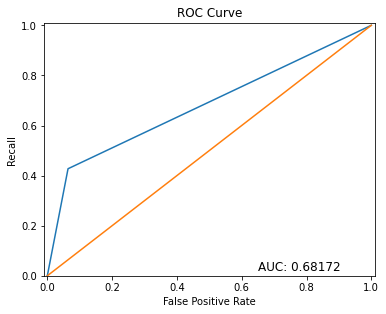

In [14]:
# Utilizamos nuestra función para crear el grafico plot_roc

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test,
    predictions= predict_tree
)

fig.tight_layout(pad=3.0)

**Conclusion**

Hemos utilizado el método GridSearchCV de la librería Sklearn para poder encontrar el mejor modelo de Árbol de Decisión. 

Podemos ver que para nuestro conjunto de prueba la profundidad con mayor eficacia es de 7, el mejor criterion es "entropy", y random_state es 54321. Dando exactitud de 0.804. 

También podemos observar nuestra grafica con la curva ROC. Usando nuestro dataset de prueba obtenemos un AUC de 0.681. 


### Bosque Aleatorio

In [15]:
param_grid = {
    'random_state':[12345,54321],
    'n_estimators':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
    'max_depth':[1,2,3,4,5,6,7,8,9,10,11],
    'min_samples_split': [2, 3, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_forest = best_model.predict(features_test)

print(best_model)
print(best_score)

RandomForestClassifier(max_depth=9, min_samples_split=4, n_estimators=15,
                       random_state=12345)
0.8145228215767635


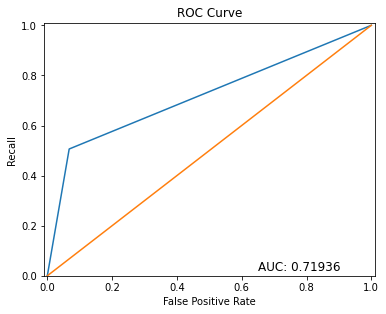

In [16]:
# Utilizamos nuestra función para crear el grafico plot_roc

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test,
    predictions= predict_forest
)

fig.tight_layout(pad=3.0)

**Conclusiones**

Al igual que en nuestro modelo anterior, hemos el método GridSearchCV de la librería Sklearn para probar distintos iperparametros.  

Podemos ver que al usar nuestro dataset de prueba los mejores iperparametros son los siguientes: max_depth=9, min_samples_split=4, n_estimators=15, random_state=12345. Dando una exactitud de 0.814. Siendo esta mejor que nuestro modelo anterior.  

También podemos ver nuestra curva ROC de este modelo con un AUC de 0.719.Tambien sindo mejor que nuestro modelo anterior. 


### Regresión Logística

In [17]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear'],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_lr = best_model.predict(features_test)

print(best_model)
print(best_score)

LogisticRegression(C=10, max_iter=500, penalty='l1', solver='liblinear')
0.7419087136929461


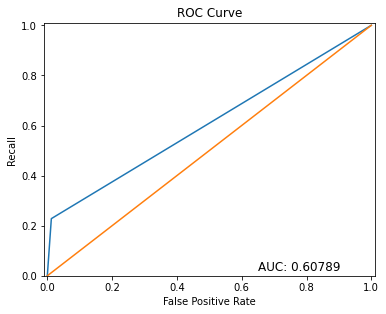

In [18]:
# Utilizamos nuestra función para crear el grafico plot_roc

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test,
    predictions= predict_lr
)

fig.tight_layout(pad=3.0)

**Conclusiones**

Al igual que en nuestro modelo anterior, hemos el método GridSearchCV de la librería Sklearn para probar distintos iperparametros.  

Podemos ver que al usar nuestro dataset de prueba los mejores iperparametros son los siguientes: C=10, max_iter=500, penalty='l1', solver='liblinear'). Con una exactitud de 0.75. 

Nuestro AUC de la gráfica de ROC curve es de 0.607. 

Todas las métricas de este modelo resultaron ser más bajas que las de los dos modelos previos. 

## Conclusiones Generales

Analizamos nuestro dataset que ya ha sido pre-procesado y hemos visto que tenemos 4 columnas con características para nuestro modelo y nuestra columna objetivo que es `is_ultra`. 

Vimos que no tenemos valores duplicados y cada columna tiene su correcto D-type. 

No tuvimos que hacer mayores cambios al dataset ya que había sido previamente procesado. 

Dividimos nuestro dataset en dataset de entrenamiento y dataset de prueba. Dejamos el 75% de nuestros dataos para entrenar los modelos y el 25% para hacer las pruebas. 

Utilizamos el método GridSearchCV de la librería Sklearn para poder encontrar los mejores modelos.
En nuestro modelo de árbol de cisión, los mejores parámetros fueron los siguientes: criterion='entropy', max_depth=7, y random_state= 54321. Y obtuvimos una exactitud de 0.804.

En nuestro modelo de bosque aleatorio, los mejores parámetros fueron los siguientes: max_depth= 9, n_estimators= 4, random_state=12345). Dando una exactitud de 0.814. Siendo esta mejor que nuestro modelo anterior.  

En nuestro modelo de regresión logistica, los mejores parámetros fueron los siguientes: C=10, max_iter=500, penalty='l1', solver='liblinear'). Con una exactitud de 0.75.

El modelo con la exactitud y AUC con mejor puntaje es nuestro modelo de árbol de decisión. Sin, embargo este modelo se demora un tiempo considerable en dar sus predicciones. Como segunda opción tenemos a el árbol de decisión también con una buena métrica y un tiempo de espera más razonable. 
